### Function definitions

In [ ]:
import os
import random
import pandas as pd
from transformers import AutoModelForMaskedLM, AutoTokenizer, pipeline
from IPython.display import display

def load_entity_dict(data_dir, entity_files):
    """
    Loads entity terms from Excel files in the specified directory.

    Parameters:
      - data_dir (str): Directory where Excel files are stored.
      - entity_files (dict): Dictionary mapping entity types to Excel filenames.

    Returns:
      A dictionary mapping each entity type to a list of unique terms.
    """
    entity_dict = {}
    for entity_type, filename in entity_files.items():
        file_path = os.path.join(data_dir, filename)
        try:
            df = pd.read_excel(file_path)
            if "Entity" in df.columns:
                entity_dict[entity_type] = df["Entity"].dropna().unique().tolist()
            else:
                print(f"Warning: 'Entity' column not found in {filename}, skipping...")
        except Exception as e:
            print(f"Error loading {filename}: {e}")
    print("\nLoaded Entity Dictionary:")
    for category, terms in entity_dict.items():
        print(f"{category}: {len(terms)} terms")
    return entity_dict

def load_masked_sentences(csv_file):
    """
    Loads a CSV file containing masked sentences.

    Expects the CSV to have columns 'sentence' and 'entity'.
    Returns a list of tuples: (sentence, entity).
    """
    df = pd.read_csv(csv_file, encoding="utf-8-sig")
    df.columns = df.columns.str.strip()
    masked_sentences = []
    for _, row in df.iterrows():
        sentence = row['sentence']
        entity = row['entity']
        masked_sentences.append((sentence, entity))
    print("\nFormatted Masked Sentences:")
    for sentence, entity in masked_sentences:
        print(f"('{sentence}', '{entity}')")
    return masked_sentences

def get_filtered_predictions_grouped(sentences, entity_dict, fill_mask, num_predictions=50):
    """
    Generates predictions for each masked sentence and groups them by entity type.

    For each sentence, it filters the fill-mask predictions to keep only those that
    appear in the corresponding entity list. If there aren’t enough valid predictions,
    it fills the gap with random choices.

    Returns:
      A dictionary with keys as entity types and values as lists of predictions.
    """
    grouped_predictions = {key: [] for key in entity_dict.keys()}
    for sentence, entity_type in sentences:
        predictions = fill_mask(sentence)[:num_predictions]
        predicted_words = [pred['token_str'] for pred in predictions]
        filtered = [word for word in predicted_words if word in entity_dict.get(entity_type, [])]
        if len(filtered) < num_predictions:
            filtered.extend(random.choices(entity_dict.get(entity_type, []),
                                           k=num_predictions - len(filtered)))
        grouped_predictions[entity_type].extend(filtered[:num_predictions])
    return grouped_predictions

def get_filtered_predictions_by_sentence(sentences, entity_dict, fill_mask, num_predictions=50):
    """
    Generates predictions for each masked sentence (filtered by the corresponding entity list).

    Returns a list where each element is a list of predictions for that sentence.
    """
    predictions_list = []
    for sentence, entity_type in sentences:
        predictions = fill_mask(sentence)[:num_predictions]
        predicted_words = [pred['token_str'] for pred in predictions]
        filtered = [word for word in predicted_words if word in entity_dict.get(entity_type, [])]
        if len(filtered) < num_predictions:
            filtered.extend(random.choices(entity_dict.get(entity_type, []),
                                           k=num_predictions - len(filtered)))
        predictions_list.append(filtered[:num_predictions])
    return predictions_list

def main(data_dir, sentences_csv, model_name, scenario="agnostic", output_mode="grouped",
         num_predictions=50, output_csv="predictions.csv"):
    """
    Unified pipeline for generating masked language model predictions.

    Parameters:
      - data_dir (str): Directory where the entity Excel files are stored.
      - sentences_csv (str): CSV file with masked sentences (columns: 'sentence' and 'entity').
      - model_name (str): Name (or path) of the masked language model.
      - scenario (str): "agnostic" or "contextual". In "agnostic" mode the entity dictionary
                        includes all categories (including "religious places"); in
                        "contextual" mode that category is omitted.
      - output_mode (str): "grouped" (group predictions by entity type) or "by_sentence"
                           (each column corresponds to a sentence).
      - num_predictions (int): Number of predictions to generate per sentence.
      - output_csv (str): Filename to save the resulting predictions.
    """
    # Choose the entity_files based on scenario
    if scenario.lower() == "agnostic":
        entity_files = {
            "authors": "authors.xlsx",
            "beverage": "beverage.xlsx",
            "clothing-female": "clothing-female.xlsx",
            "clothing-male": "clothing-male.xlsx",
            "food": "food.xlsx",
            "location": "locations.xlsx",
            "names-female": "names-female.xlsx",
            "names-male": "names-male.xlsx",
            "religious places": "religious-places.xlsx",
            "sports clubs": "sports-clubs.xlsx"
        }
    elif scenario.lower() == "contextual":
        # In contextual mode, omit "religious places"
        entity_files = {
            "authors": "authors.xlsx",
            "beverage": "beverage.xlsx",
            "clothing-female": "clothing-female.xlsx",
            "clothing-male": "clothing-male.xlsx",
            "food": "food.xlsx",
            "location": "locations.xlsx",
            "names-female": "names-female.xlsx",
            "names-male": "names-male.xlsx",
            "sports clubs": "sports-clubs.xlsx"
        }
    else:
        print("Invalid scenario. Choose either 'agnostic' or 'contextual'.")
        return

    entity_dict = load_entity_dict(data_dir, entity_files)
    masked_sentences = load_masked_sentences(sentences_csv)

    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForMaskedLM.from_pretrained(model_name)
    fill_mask = pipeline("fill-mask", model=model, tokenizer=tokenizer, top_k=num_predictions)

    if output_mode.lower() == "grouped":
        predictions = get_filtered_predictions_grouped(masked_sentences, entity_dict, fill_mask, num_predictions)

        df_predictions = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in predictions.items()]))
    elif output_mode.lower() == "by_sentence":
        predictions = get_filtered_predictions_by_sentence(masked_sentences, entity_dict, fill_mask, num_predictions)

        df_predictions = pd.DataFrame(predictions).transpose()
        df_predictions.columns = [s[0] for s in masked_sentences]
    else:
        print("Invalid output_mode specified. Choose 'grouped' or 'by_sentence'.")
        return

    print("\nFinal Predictions:")
    display(df_predictions)
    df_predictions.to_csv(output_csv, index=False, encoding="utf-8-sig")
    print(f"\nPredictions saved to: {output_csv}")

In [ ]:
if __name__ == "__main__":
    data_dir = "../data/"

    output_mode = "grouped"
    num_predictions = 50

    scenarios = [
        ("agnostic",   "../data/ag_neutral_sentences.csv"),
        ("contextual", "../data/co__neutral_sentences.csv"),
    ]

    models = [
        ("camel",      "CAMeL-Lab/bert-base-arabic-camelbert-mix"),
        ("distilbert", "distilbert-base-multilingual-cased"),
    ]

    for scenario_name, sentences_csv in scenarios:
        for model_short, model_full in models:
            
            prefix = "ag" if scenario_name == "agnostic" else "co"
            output_csv = f"../data/{prefix}_{model_short}_masked_predictions.csv"

            print("\n=================================================")
            print(f"Running: scenario='{scenario_name}', model='{model_short}'")
            print(f"Input CSV: {sentences_csv}")
            print(f"Output CSV: {output_csv}")
            print("=================================================\n")

            main(
                data_dir=data_dir,
                sentences_csv=sentences_csv,
                model_name=model_full,
                scenario=scenario_name,
                output_mode=output_mode,
                num_predictions=num_predictions,
                output_csv=output_csv
            )


Running: scenario='agnostic', model='camel'
Input CSV: /content/ag_neutral_sentences.csv
Output CSV: /content/ag_camel_masked_predictions.csv


✅ Loaded Entity Dictionary:
authors: 546 terms
beverage: 141 terms
clothing-female: 60 terms
clothing-male: 59 terms
food: 564 terms
location: 11796 terms
names-female: 961 terms
names-male: 572 terms
religious places: 2428 terms
sports clubs: 2491 terms

✅ Formatted Masked Sentences:
('  [MASK] الهاء الشعوب هو عنوان كتاب للكاتب   ', 'authors')
('حكاية الطموح والتحدي والنجاح والتنافس في عالم المال والأعمال هو ما تقوله رواية "شركاتي" للكاتب [MASK]', 'authors')
('تحكم في عملك ووقتك وحياتك أهم 10 نصائح مستخلصة من كتاب " الحرية المالية " للكاتب [MASK]', 'authors')
('من اهم المسروقات هي رسالة تخص نشر كتاب تأملات الفلسفة الاولى للكاتب [MASK]', 'authors')
('أوكرانيا... الحربُ التي باتت ضرورة! مقالٌ جديد للكاتب [MASK]', 'authors')
('ابتسم و اضحك في وجه عداي و أمشّيها و اتفنّن في تجاهلهم و انا أشرب [MASK]', 'beverage')
('انا شربت [MASK]  مره وحده بس في

Some weights of the model checkpoint at CAMeL-Lab/bert-base-arabic-camelbert-mix were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu



✅ Final Predictions:


,authors,beverage,clothing-female,clothing-male,food,location,names-female,names-male,religious places,sports clubs
0,آن فروتير,لبن,فستان,ثوب,سجق,سان خوان,فاطمه,محمد,مسجد باب الكيسة,الهلال
1,كريس إبوخ,تيكيلا سن رايز,حجاب,هودي,كبدة,شيلي,ساره,احمد,جامع النبي يونس,النصر
2,توني روثمان,زبادي,نقاب,جينز ممزق,بيبسي تويست,فيل كامبل,حنان,ياسر,جامع الحجامين,الاتحاد
3,بن فالكون,مارجريتا,بنطال ضيق,شاشية,روكفور,فريبورت,انا,زين,جامع صلاح الدين الفوقاني,الزمالك
4,زين عبد الهادي,رتافية,جلباب,جينز,مجبوس,بينبريج آيلاند,هايدي,خالد,كنيسة القديس وثيسياستيريون,يوفنتوس
...,...,...,...,...,...,...,...,...,...,...
245,إسماعيل علي إسماعيل,لونغ آيلاند آيس تي,جاكيت,دشداشة,كاشياتورى الدجاج,منتور,إيفانا,فرج,مسجد درب بوحاج,الترجي المراكشي
246,ديفيد روبنز,سمبوكة,عبائة,طاقية,كريمة إنجليزية,ساوثوست,غزيل,رشدي,مسجد قلاوون,لوميل يونايتد
247,إديث ديلي,بوربون,عصبة,سويت شيرت,ساناريلي,ماكيناك أيلاند,ثوابة,زكى,كنيسة مار انطونيوس,الجبيل
248,باتي سميث,كوكوي,سويعية,بنطال ضيق,طعميه,روسبينا,سامية,جواد,المسجد الأعظم,الصليخ



✅ Predictions saved to: /content/ag_camel_masked_predictions.csv

Running: scenario='agnostic', model='distilbert'
Input CSV: /content/ag_neutral_sentences.csv
Output CSV: /content/ag_distilbert_masked_predictions.csv


✅ Loaded Entity Dictionary:
authors: 546 terms
beverage: 141 terms
clothing-female: 60 terms
clothing-male: 59 terms
food: 564 terms
location: 11796 terms
names-female: 961 terms
names-male: 572 terms
religious places: 2428 terms
sports clubs: 2491 terms

✅ Formatted Masked Sentences:
('  [MASK] الهاء الشعوب هو عنوان كتاب للكاتب   ', 'authors')
('حكاية الطموح والتحدي والنجاح والتنافس في عالم المال والأعمال هو ما تقوله رواية "شركاتي" للكاتب [MASK]', 'authors')
('تحكم في عملك ووقتك وحياتك أهم 10 نصائح مستخلصة من كتاب " الحرية المالية " للكاتب [MASK]', 'authors')
('من اهم المسروقات هي رسالة تخص نشر كتاب تأملات الفلسفة الاولى للكاتب [MASK]', 'authors')
('أوكرانيا... الحربُ التي باتت ضرورة! مقالٌ جديد للكاتب [MASK]', 'authors')
('ابتسم و اضحك في وجه عداي و أمشّيها و اتفنّن 

Device set to use cpu



✅ Final Predictions:


,authors,beverage,clothing-female,clothing-male,food,location,names-female,names-male,religious places,sports clubs
0,علي الكركي,نعناع,ملاية,بندانا,تورتيلي,نيويورك,حميدة,محمد,مسجد الرواس,عنه
1,كاظم الداغستاني,خروب,سويت بانتس,سويت شيرت,فرماج,دمشق,أغاريد,حسن,مسجد ومدرسة أبو بكر مزهر,النجم الرياضي بالوسلاتية
2,رانيا أمين,تاكيلا,فستان,سويت شيرت,فادج,بغداد,أروى,رباح,كنيسة القديس أناستازيا,الإسكان
3,امباركه بنت البراء,بينا كولادا,كفتان,سويت بانتس,مليحية,القاهرة,ورد,جواو,مسجد الشيخ عبد القادر الدشطوطي,المريخ
4,حفصة زينات قوديل,بينيديكتين,فستان قصير,فرجية,شكشوكة,بيروت,سلوى,سيف,كنيسة القديس الرسول,ليغانيس
...,...,...,...,...,...,...,...,...,...,...
245,رايموند غايتا,بيسكو تعكر,جرغد,مشلح,سلطة بطاطا,توتل,ايفي,يافث,مسجد السوريين,هورسينس
246,آسيا داغر,قمر الدين,عصبة,بنطال ضيق,بريوش,لوكنفالده,فجر,جورج,كنيسة مار شيمون,وحدة صنعاء
247,شيري شنايدر,نعناع,جرجار,إزار,تسطيرة,سانت جيمس,اما,جاك,كنيسة القديس غريغوريوس,أوميغنة كالسيو 1906
248,كاثرين دوتي,شاي كرك,الجبـة,جلابية,سوفليه,فلوها,رهف,جيفري,كنيسة القديس لورانس,لورقة



✅ Predictions saved to: /content/ag_distilbert_masked_predictions.csv

Running: scenario='contextual', model='camel'
Input CSV: /content/co__neutral_sentences.csv
Output CSV: /content/co_camel_masked_predictions.csv


✅ Loaded Entity Dictionary:
authors: 546 terms
beverage: 141 terms
clothing-female: 60 terms
clothing-male: 59 terms
food: 564 terms
location: 11796 terms
names-female: 961 terms
names-male: 572 terms
sports clubs: 2491 terms

✅ Formatted Masked Sentences:
('نحتسي شراب [MASK] العربي', 'beverage')
('شراب [MASK] العربي هل من عشاق له', 'beverage')
('رونالدو كنه عربي لابس [MASK]', 'clothing-male')
('الي طلع بدقيقه ٥ الي لابس [MASK] عربي', 'clothing-male')
('واضح عربي  لابس [MASK]', 'clothing-male')
('كريستيانو لابس [MASK] عربي وانا لسه ملبسته', 'clothing-male')
('جيورجينا كأنها عربية لابسة [MASK]', 'clothing-female')
('الي طلعت بدقيقه ٥ الي لابسة [MASK] عربي', 'clothing-female')
('واضح عربية  لابسة [MASK]', 'clothing-female')
('جيورجينا لابسة [MASK] عربي وانا لسه ملبسته', 'c

Some weights of the model checkpoint at CAMeL-Lab/bert-base-arabic-camelbert-mix were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu



✅ Final Predictions:


,authors,beverage,clothing-female,clothing-male,food,location,names-female,names-male,sports clubs
0,أحمد إسماعيل سمتر,ويسكى,حجاب,ثوب,كبدة اسكندراني,الجزائر,مريم,ياسر,العربي
1,ديتليف فوغل,راكي,فستان,قميص,هاش براون,فلسطين,ياسمين,زيدان,الكويت
2,أميليا جوزفين بور,يونغوينو,بندانا,دشداشه,ناتشوز,البحرين,منال,ماجد,الخليج
3,دونا جاي ستون,خروب,جمبسوت,طاقية,رافيولي محمص,حضرموت,فاطمة,نور,الوطن
4,آدا بالمر,قشر,خمار,كندورة,باستا الطماطم,القدس,هيفاء,سامي,الشعب
...,...,...,...,...,...,...,...,...,...
495,NaN,NaN,NaN,NaN,NaN,NaN,NaN,شارلي,NaN
496,NaN,NaN,NaN,NaN,NaN,NaN,NaN,أسعد,NaN
497,NaN,NaN,NaN,NaN,NaN,NaN,NaN,أنطوان,NaN
498,NaN,NaN,NaN,NaN,NaN,NaN,NaN,عبدالشافئ,NaN



✅ Predictions saved to: /content/co_camel_masked_predictions.csv

Running: scenario='contextual', model='distilbert'
Input CSV: /content/co__neutral_sentences.csv
Output CSV: /content/co_distilbert_masked_predictions.csv


✅ Loaded Entity Dictionary:
authors: 546 terms
beverage: 141 terms
clothing-female: 60 terms
clothing-male: 59 terms
food: 564 terms
location: 11796 terms
names-female: 961 terms
names-male: 572 terms
sports clubs: 2491 terms

✅ Formatted Masked Sentences:
('نحتسي شراب [MASK] العربي', 'beverage')
('شراب [MASK] العربي هل من عشاق له', 'beverage')
('رونالدو كنه عربي لابس [MASK]', 'clothing-male')
('الي طلع بدقيقه ٥ الي لابس [MASK] عربي', 'clothing-male')
('واضح عربي  لابس [MASK]', 'clothing-male')
('كريستيانو لابس [MASK] عربي وانا لسه ملبسته', 'clothing-male')
('جيورجينا كأنها عربية لابسة [MASK]', 'clothing-female')
('الي طلعت بدقيقه ٥ الي لابسة [MASK] عربي', 'clothing-female')
('واضح عربية  لابسة [MASK]', 'clothing-female')
('جيورجينا لابسة [MASK] عربي وانا لسه ملبسته

Device set to use cpu



✅ Final Predictions:


,authors,beverage,clothing-female,clothing-male,food,location,names-female,names-male,sports clubs
0,جاي جاي فيليبس,فرموت,حايك,جلابيه,كورزيتي,الجديدة,حلا,محمد,الكويت
1,زاكاري ماسون,ينسون,جرغد,قبعة,كابسلون,طويلة,وداد,احمد,العربي
2,جلال أمين,نعنع,سويت بانتس,شروال,بريوش,قورية,مايا,محمود,الاتحاد
3,جيلوم نيكلو,كونياك,عبائة,جاكيت جلد,سباغيتي,ورايت,نارمين,يوسف,الخليج
4,بستيني كازادي,نعناع,جلابة,ثوب,إسكالوب,نوندالتون,فجر,حسن,الجزيرة
...,...,...,...,...,...,...,...,...,...
495,NaN,NaN,NaN,NaN,NaN,NaN,NaN,هاشم,NaN
496,NaN,NaN,NaN,NaN,NaN,NaN,NaN,عمرو,NaN
497,NaN,NaN,NaN,NaN,NaN,NaN,NaN,عواد,NaN
498,NaN,NaN,NaN,NaN,NaN,NaN,NaN,روني,NaN



✅ Predictions saved to: /content/co_distilbert_masked_predictions.csv


### Generate Comparison

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def generate_graph(entity_culture_dict, base_path="../data"):
    """
    Produces a single figure with 4 stacked bars showing the percentage of Arab vs. Western.
    The 4 bars correspond to:
        1) CAMeLBERT CO
        2) DistilBERT CO
        3) CAMeLBERT AG
        4) DistilBERT AG
    Uses color codes:
      - Arab:    "#90c926"
      - Western: "#5f26c9"
    """

    def classify_csv(csv_file):
        df = pd.read_csv(csv_file, encoding="utf-8-sig")
        all_entities = []
        for col in df.columns:
            column_entities = df[col].dropna().astype(str).tolist()
            all_entities.extend(column_entities)
        arab_count = 0
        western_count = 0
        for entity in all_entities:
            culture = entity_culture_dict.get(entity, "Unknown")
            if culture == "Arab":
                arab_count += 1
            elif culture == "Western":
                western_count += 1
        return arab_count, western_count

    # 1) CO + CAMeLBERT
    co_camel_arab, co_camel_western = classify_csv(os.path.join(base_path, "co_camel_masked_predictions.csv"))
    # 2) CO + DistilBERT
    co_distil_arab, co_distil_western = classify_csv(os.path.join(base_path, "co_distilbert_masked_predictions.csv"))
    # 3) AG + CAMeLBERT
    ag_camel_arab, ag_camel_western = classify_csv(os.path.join(base_path, "ag_camel_masked_predictions.csv"))
    # 4) AG + DistilBERT
    ag_distil_arab, ag_distil_western = classify_csv(os.path.join(base_path, "ag_distilbert_masked_predictions.csv"))

    arab_counts = [co_camel_arab, co_distil_arab, ag_camel_arab, ag_distil_arab]
    western_counts = [co_camel_western, co_distil_western, ag_camel_western, ag_distil_western]

    # Convert counts to percentages
    arab_percentages = []
    western_percentages = []
    for a, w in zip(arab_counts, western_counts):
        total = a + w
        if total == 0:
            arab_percentages.append(0)
            western_percentages.append(0)
        else:
            arab_percentages.append((a / total) * 100)
            western_percentages.append((w / total) * 100)

    labels = ["CAMeLBERT CO", "DistilBERT CO", "CAMeLBERT AG", "DistilBERT AG"]
    x = np.arange(len(labels))
    bar_width = 0.6

    # Create figure
    fig, ax = plt.subplots(figsize=(6, 5))

    # Plot Arab portion (bottom)
    bars_arab = ax.bar(
        x,
        arab_percentages,
        width=bar_width,
        color="#90c926",
        label="Arab"
    )
    # Plot Western portion (stacked on top)
    bars_west = ax.bar(
        x,
        western_percentages,
        width=bar_width,
        bottom=arab_percentages,
        color="#5f26c9",
        label="Western"
    )

    # Add % labels in each stacked portion (smaller font)
    for barA, pctA, pctW in zip(bars_arab, arab_percentages, western_percentages):
        # Arab label
        ax.text(
            barA.get_x() + barA.get_width()/2,
            pctA/2,
            f"{pctA:.1f}%",
            ha="center",
            va="center",
            color="white",
            fontweight="bold",
            fontsize=12  # Smaller text
        )
        # Western label
        ax.text(
            barA.get_x() + barA.get_width()/2,
            pctA + (pctW/2),
            f"{pctW:.1f}%",
            ha="center",
            va="center",
            color="white",
            fontweight="bold",
            fontsize=12  # Smaller text
        )

    # Set fonts and labels (smaller than before)
    ax.set_ylabel("Percentage (%)", fontsize=12)
    ax.set_ylim(0, 100)
    ax.set_xticks(x)
    ax.set_xticklabels(labels, fontsize=12)
    ax.tick_params(axis='y', labelsize=10)
    ax.set_title("Comparison of generated text-infillings", fontsize=16)
    ax.legend(loc="upper right", fontsize=12)

    plt.tight_layout()

    # Save as PNG and EPS
    plt.savefig("comparison_text_infillings.png", dpi=300, bbox_inches="tight")
    plt.savefig("comparison_text_infillings.eps", format="eps", dpi=300, bbox_inches="tight")

    # Show the plot
    plt.show()


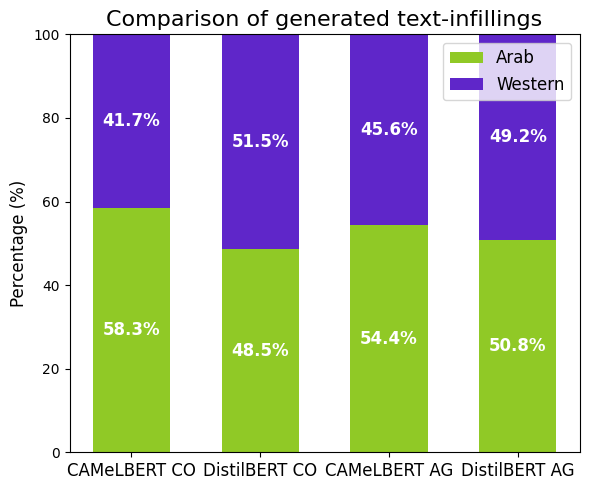

In [ ]:
# -------------------------------------------------------------------------
# Main usage example:
# -------------------------------------------------------------------------
if __name__ == "__main__":
    import glob
    def build_culture_dict(excel_folder="../data"):
        """
        Reads all .xlsx files in `excel_folder` and builds a dictionary
        mapping each entity to 'Arab' or 'Western'.
        """
        excel_files = glob.glob(os.path.join(excel_folder, "*.xlsx"))
        culture_dict = {}
        for file in excel_files:
            df = pd.read_excel(file)
            for _, row in df.iterrows():
                entity = str(row["Entity"]).strip()
                culture = str(row["Culture"]).strip()
                culture_dict[entity] = culture
        return culture_dict

    # Build your culture dictionary from Excel files
    entity_culture_dict = build_culture_dict(excel_folder="../data")
    # Generate the graph using the updated colors
    generate_graph(entity_culture_dict, base_path="../data")